# 拡散過程の可視化

このノートブックでは、軌道データが拡散過程でノイズになっていく様子を可視化します。

In [1]:
# CLAUDE_ADDED
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# パスを追加
current_dir = os.getcwd()
src_dir = os.path.dirname(current_dir)
sys.path.insert(0, current_dir)
sys.path.insert(0, src_dir)
sys.path.insert(0, os.path.join(src_dir, 'DataPreprocess'))

# モデルとデータ処理のインポート
from hybrid_model import HybridTrajectoryModel
from DataPreprocessForOverFitting import load_processed_data

In [2]:
# データの読み込み
data_path = '../../data/Datasets/overfitting_dataset.npz'
trajectories, conditions = load_processed_data(data_path)
print(f"軌道データ形状: {trajectories.shape}")
print(f"条件データ形状: {conditions.shape}")

データを読み込みました:
  軌道データ: (840, 101, 2)
  条件データ: (840, 5)
  軌道データ範囲: [-1.000, 1.000]
  条件データ範囲: [-2.430, 24.713]
軌道データ形状: (840, 101, 2)
条件データ形状: (840, 5)


In [3]:
# モデルの読み込み（学習済みモデルが存在する場合）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

# モデル設定
model_config = {
    'input_dim': 2,
    'condition_dim': 5,
    'lstm_hidden_dim': 128,
    'lstm_num_layers': 2,
    'diffusion_hidden_dim': 256,
    'diffusion_num_layers': 4,
    'moving_average_window': 10,
    'num_diffusion_steps': 1000
}

model = HybridTrajectoryModel(**model_config).to(device)

使用デバイス: cuda


In [4]:
# 学習済みモデルが存在する場合は読み込み
model_path = 'outputs/hybrid_model_final.pth'
if os.path.exists(model_path):
    model = HybridTrajectoryModel.load_model(model_path, device=device)
    print("学習済みモデルを読み込みました")
else:
    print("学習済みモデルが見つかりません。新しいモデルを使用します。")

model.eval()

学習済みモデルを読み込みました


HybridTrajectoryModel(
  (low_freq_model): LowFreqLSTM(
    (condition_proj): Linear(in_features=5, out_features=128, bias=True)
    (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.1)
    (output_proj): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (high_freq_model): SimpleDiffusionMLP(
    (time_embedding): TimeEmbedding(
      (sinusoidal_embedding): SinusoidalPositionEmbedding()
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (condition_proj): Linear(in_features=5, out_features=256, bias=True)
    (input_proj): Linear(in_features=2, out_features=256, bias=True)
    (layers): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.1, inplace=False)
      )
    )
    (output_p

In [5]:
def visualize_diffusion_process(trajectory_idx=0, max_steps=None):
    """
    指定された軌道の拡散過程を可視化
    
    Args:
        trajectory_idx: 可視化する軌道のインデックス
        max_steps: 最大拡散ステップ数（Noneの場合は全ステップ）
    """
    # 元の軌道を取得
    original_trajectory = torch.tensor(trajectories[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
    condition = torch.tensor(conditions[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
    
    # データ分解して高周波成分を取得
    with torch.no_grad():
        # 低周波成分（LSTM）と高周波成分（拡散モデル）に分解
        low_freq, high_freq = model.decomposer.decompose(original_trajectory)
        
        # 拡散ステップ数を設定
        total_steps = model.diffusion.num_timesteps
        if max_steps is None:
            max_steps = total_steps
        else:
            max_steps = min(max_steps, total_steps)
        
        # 拡散過程でのノイズ追加を可視化
        diffusion_steps = [0, max_steps//10, max_steps//5, max_steps//3, max_steps//2, 
                          2*max_steps//3, 4*max_steps//5, 9*max_steps//10, max_steps-1]
        
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        
        for i, t_step in enumerate(diffusion_steps):
            # タイムステップテンソルを作成
            t = torch.tensor([t_step], device=device, dtype=torch.long)
            
            # ノイズを追加
            noisy_high_freq = model.diffusion.add_noise(high_freq, t)
            
            # 軌道を再構成
            reconstructed_trajectory = low_freq + noisy_high_freq
            
            # CPUに移動して可視化
            traj_cpu = reconstructed_trajectory[0].cpu().numpy()
            orig_cpu = original_trajectory[0].cpu().numpy()
            
            ax = axes[i]
            ax.plot(orig_cpu[:, 0], orig_cpu[:, 1], 'k-', linewidth=3, alpha=0.7, label='Original')
            ax.plot(traj_cpu[:, 0], traj_cpu[:, 1], 'r-', linewidth=2, label=f'Noisy (t={t_step})')
            ax.scatter(orig_cpu[0, 0], orig_cpu[0, 1], c='green', s=100, marker='o', label='Start', zorder=5)
            ax.scatter(orig_cpu[-1, 0], orig_cpu[-1, 1], c='blue', s=100, marker='s', label='End', zorder=5)
            ax.set_title(f'Diffusion Step: {t_step} / {max_steps-1}\nNoise Level: {t_step/(max_steps-1):.2f}')
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axis('equal')
        
        plt.suptitle(f'軌道 {trajectory_idx} の拡散過程\n条件: {conditions[trajectory_idx]}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        return diffusion_steps

In [6]:
def visualize_noise_progression(trajectory_idx=0, num_steps=20):
    """
    ノイズが徐々に追加される様子を詳細に可視化
    
    Args:
        trajectory_idx: 可視化する軌道のインデックス
        num_steps: 可視化するステップ数
    """
    # 元の軌道を取得
    original_trajectory = torch.tensor(trajectories[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
    condition = torch.tensor(conditions[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        # データ分解
        low_freq, high_freq = model.decomposer.decompose(original_trajectory)
        
        # 拡散ステップを等間隔で選択
        total_steps = model.diffusion.num_timesteps
        step_indices = np.linspace(0, total_steps-1, num_steps, dtype=int)
        
        # 複数の軌道を1つのプロットに表示
        plt.figure(figsize=(12, 10))
        
        # 元の軌道
        orig_cpu = original_trajectory[0].cpu().numpy()
        plt.plot(orig_cpu[:, 0], orig_cpu[:, 1], 'k-', linewidth=4, alpha=0.8, label='Original', zorder=10)
        
        # カラーマップの設定
        colors = plt.cm.viridis(np.linspace(0, 1, len(step_indices)))
        
        for i, t_step in enumerate(step_indices):
            # ノイズを追加
            t = torch.tensor([t_step], device=device, dtype=torch.long)
            noisy_high_freq = model.diffusion.add_noise(high_freq, t)
            reconstructed_trajectory = low_freq + noisy_high_freq
            
            # 可視化
            traj_cpu = reconstructed_trajectory[0].cpu().numpy()
            alpha = 0.3 + 0.5 * (i / len(step_indices))  # 後半ほど濃く
            plt.plot(traj_cpu[:, 0], traj_cpu[:, 1], color=colors[i], 
                    linewidth=2, alpha=alpha, label=f't={t_step}')
        
        # スタート・エンドポイント
        plt.scatter(orig_cpu[0, 0], orig_cpu[0, 1], c='green', s=200, marker='o', 
                   label='Start', zorder=15, edgecolors='black', linewidth=2)
        plt.scatter(orig_cpu[-1, 0], orig_cpu[-1, 1], c='red', s=200, marker='s', 
                   label='End', zorder=15, edgecolors='black', linewidth=2)
        
        plt.title(f'軌道 {trajectory_idx} の拡散過程 (詳細)\n' + 
                 f'条件: MovementTime={conditions[trajectory_idx][0]:.3f}, EndpointError={conditions[trajectory_idx][1]:.3f}, ' +
                 f'Jerk={conditions[trajectory_idx][2]:.3f}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

In [7]:
def interactive_diffusion_visualization():
    """
    インタラクティブな拡散過程可視化
    """
    # ウィジェットの作成
    trajectory_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(trajectories)-1,
        step=1,
        description='軌道ID:',
        style={'description_width': 'initial'}
    )
    
    diffusion_step_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=model.diffusion.num_timesteps-1,
        step=1,
        description='拡散ステップ:',
        style={'description_width': 'initial'}
    )
    
    def update_plot(trajectory_idx, diffusion_step):
        clear_output(wait=True)
        
        # 軌道とノイズ追加
        original_trajectory = torch.tensor(trajectories[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            low_freq, high_freq = model.decomposer.decompose(original_trajectory)
            
            # ノイズ追加
            t = torch.tensor([diffusion_step], device=device, dtype=torch.long)
            noisy_high_freq = model.diffusion.add_noise(high_freq, t)
            reconstructed_trajectory = low_freq + noisy_high_freq
            
            # 可視化
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # 軌道の比較
            orig_cpu = original_trajectory[0].cpu().numpy()
            traj_cpu = reconstructed_trajectory[0].cpu().numpy()
            low_freq_cpu = low_freq[0].cpu().numpy()
            
            ax1.plot(orig_cpu[:, 0], orig_cpu[:, 1], 'k-', linewidth=3, label='Original')
            ax1.plot(low_freq_cpu[:, 0], low_freq_cpu[:, 1], 'b--', linewidth=2, label='Low Frequency')
            ax1.plot(traj_cpu[:, 0], traj_cpu[:, 1], 'r-', linewidth=2, label='With Noise')
            ax1.scatter(orig_cpu[0, 0], orig_cpu[0, 1], c='green', s=100, marker='o', label='Start')
            ax1.scatter(orig_cpu[-1, 0], orig_cpu[-1, 1], c='blue', s=100, marker='s', label='End')
            ax1.set_title(f'軌道比較 (t={diffusion_step})')
            ax1.set_xlabel('X Position')
            ax1.set_ylabel('Y Position')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.axis('equal')
            
            # 時系列の比較
            time_steps = np.arange(len(orig_cpu))
            ax2.plot(time_steps, np.linalg.norm(orig_cpu, axis=1), 'k-', linewidth=3, label='Original Distance')
            ax2.plot(time_steps, np.linalg.norm(traj_cpu, axis=1), 'r-', linewidth=2, label='Noisy Distance')
            ax2.set_title(f'原点からの距離 (t={diffusion_step})')
            ax2.set_xlabel('Time Step')
            ax2.set_ylabel('Distance from Origin')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.suptitle(f'軌道 {trajectory_idx} - 拡散ステップ {diffusion_step}\n' +
                        f'ノイズレベル: {diffusion_step/(model.diffusion.num_timesteps-1):.3f}', fontsize=14)
            plt.tight_layout()
            plt.show()
            
            # 条件情報を表示
            condition = conditions[trajectory_idx]
            print(f"条件情報:")
            print(f"  動作時間: {condition[0]:.3f}")
            print(f"  終点誤差: {condition[1]:.3f}")
            print(f"  ジャーク: {condition[2]:.3f}")
            print(f"  ゴールX: {condition[3]:.3f}")
            print(f"  ゴールY: {condition[4]:.3f}")
    
    # インタラクティブウィジェット
    interactive_plot = widgets.interactive(update_plot, 
                                         trajectory_idx=trajectory_slider,
                                         diffusion_step=diffusion_step_slider)
    
    display(interactive_plot)

## 基本的な拡散過程の可視化

まず、指定した軌道の拡散過程を9つのステップで可視化します。

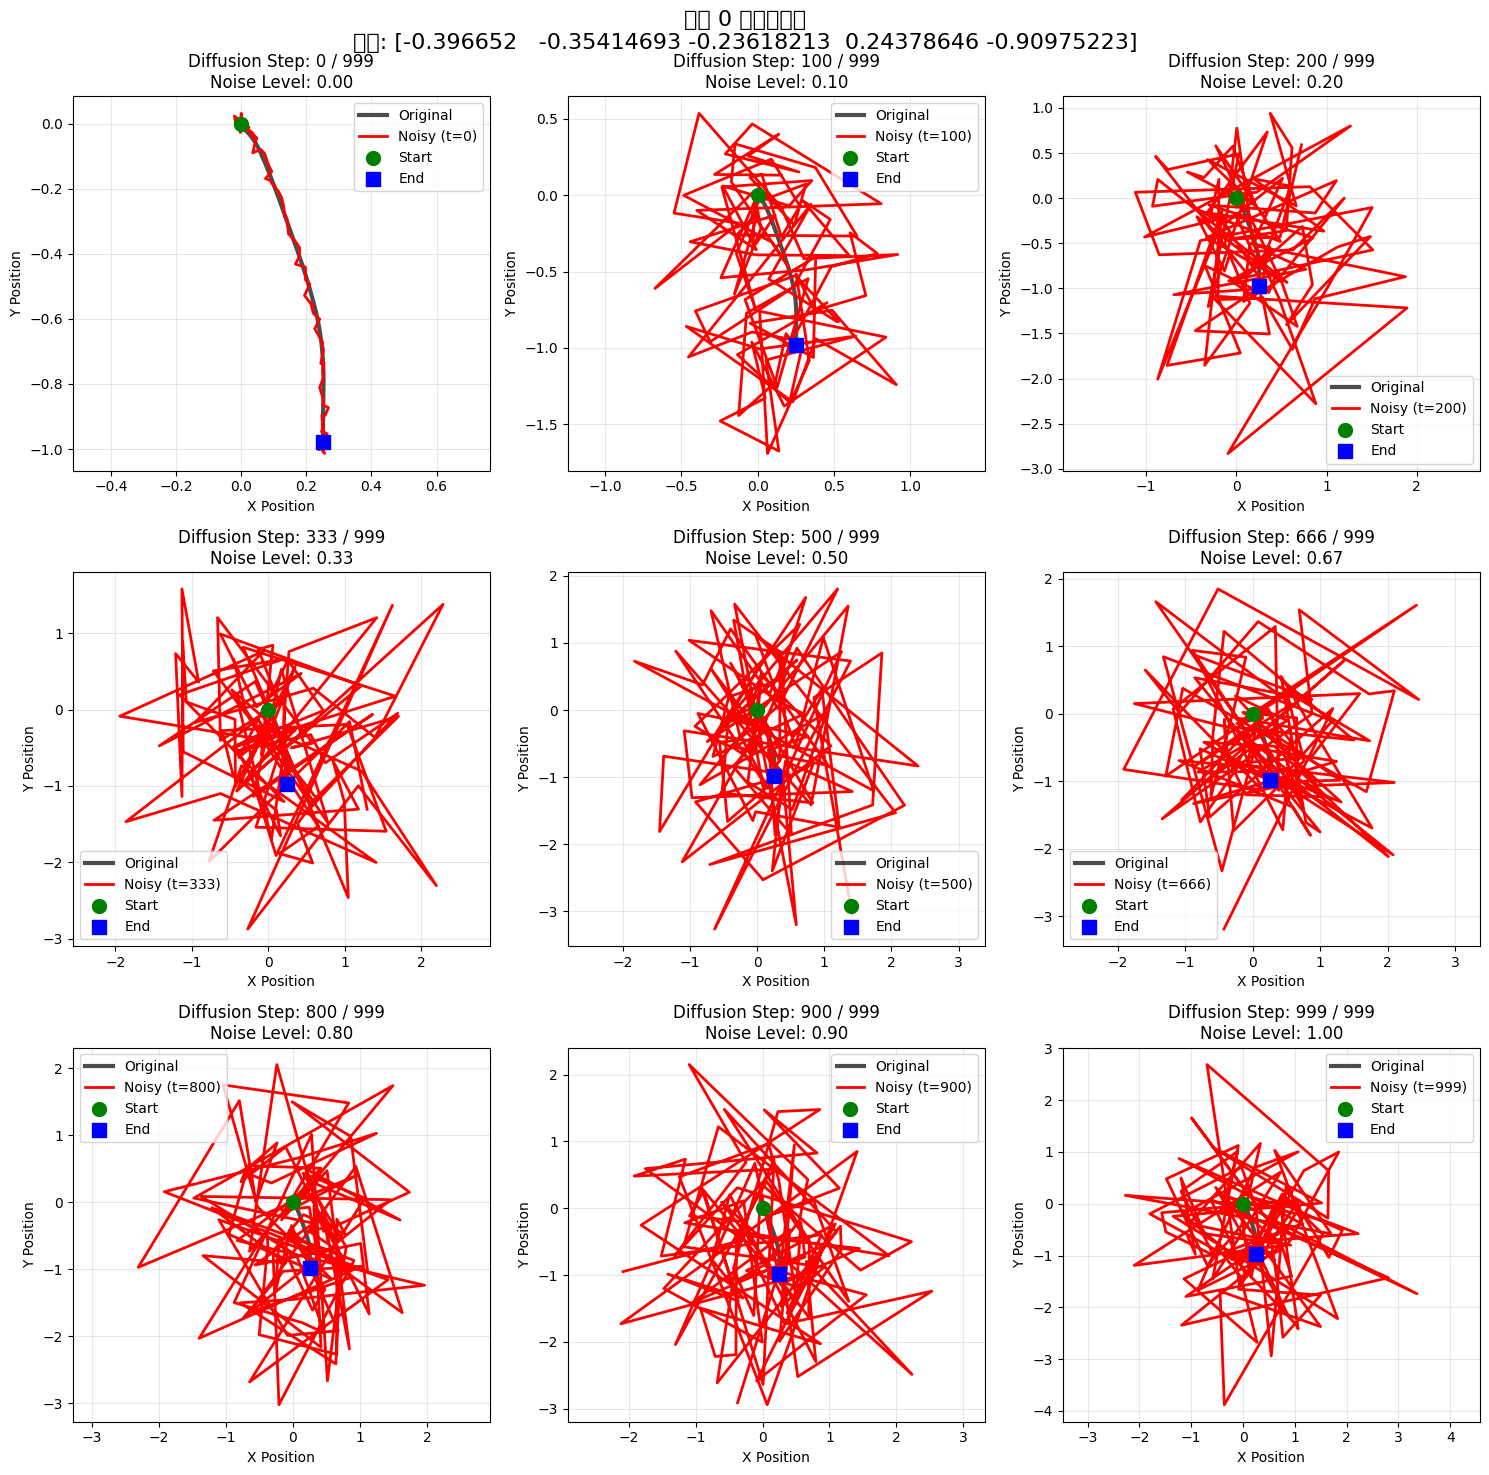

[0, 100, 200, 333, 500, 666, 800, 900, 999]

In [8]:
# 軌道0の拡散過程を可視化
visualize_diffusion_process(trajectory_idx=0, max_steps=1000)

## 詳細なノイズ進行過程

ノイズが徐々に追加される様子を1つのプロットで確認します。

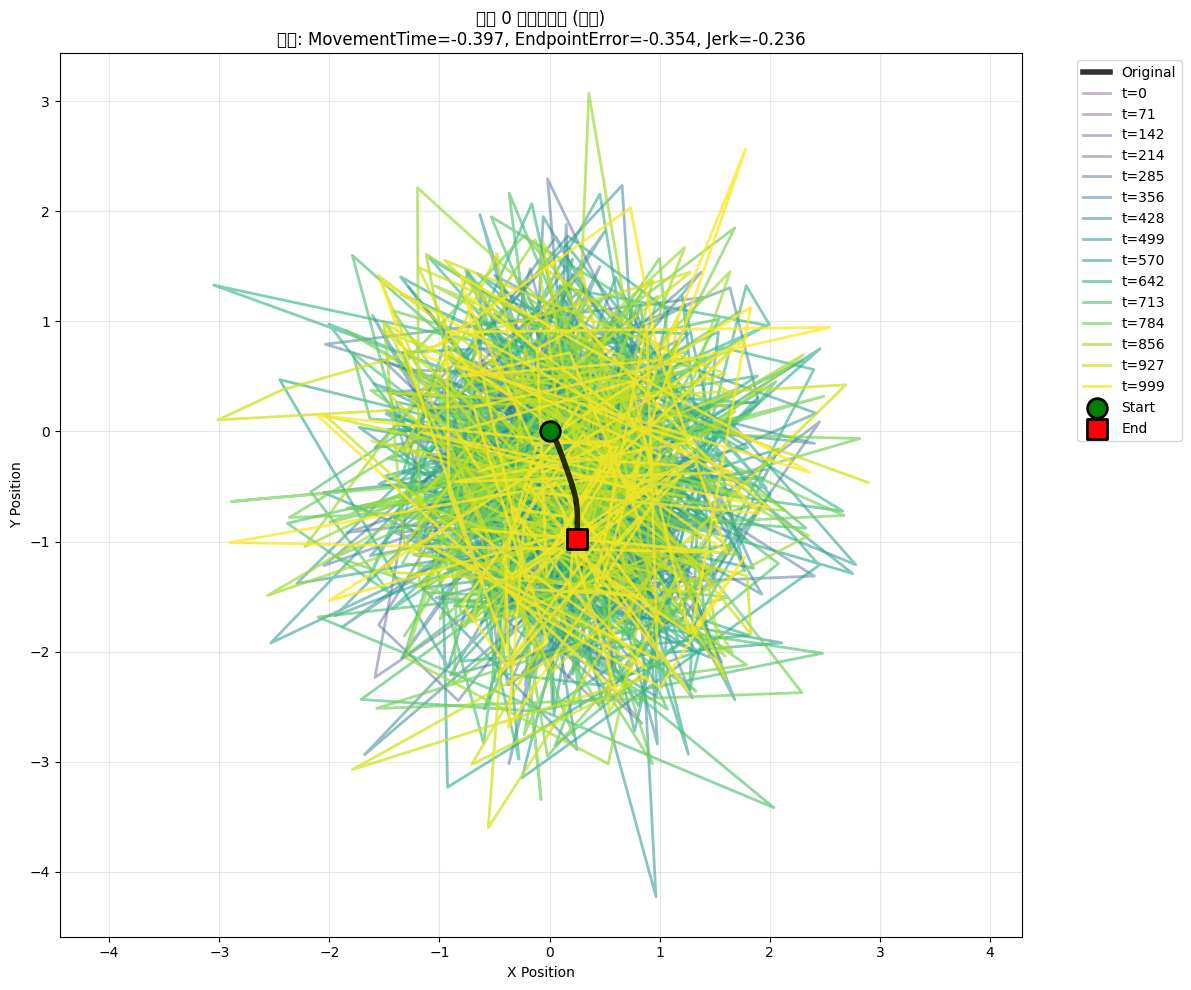

In [9]:
# 軌道0の詳細なノイズ進行過程
visualize_noise_progression(trajectory_idx=0, num_steps=15)

## インタラクティブな可視化

スライダーを使って任意の軌道と拡散ステップを選択できます。

In [10]:
# インタラクティブな可視化
interactive_diffusion_visualization()

interactive(children=(IntSlider(value=0, description='軌道ID:', max=839, style=SliderStyle(description_width='in…

## 異なる軌道の比較

複数の軌道で拡散過程を比較してみます。

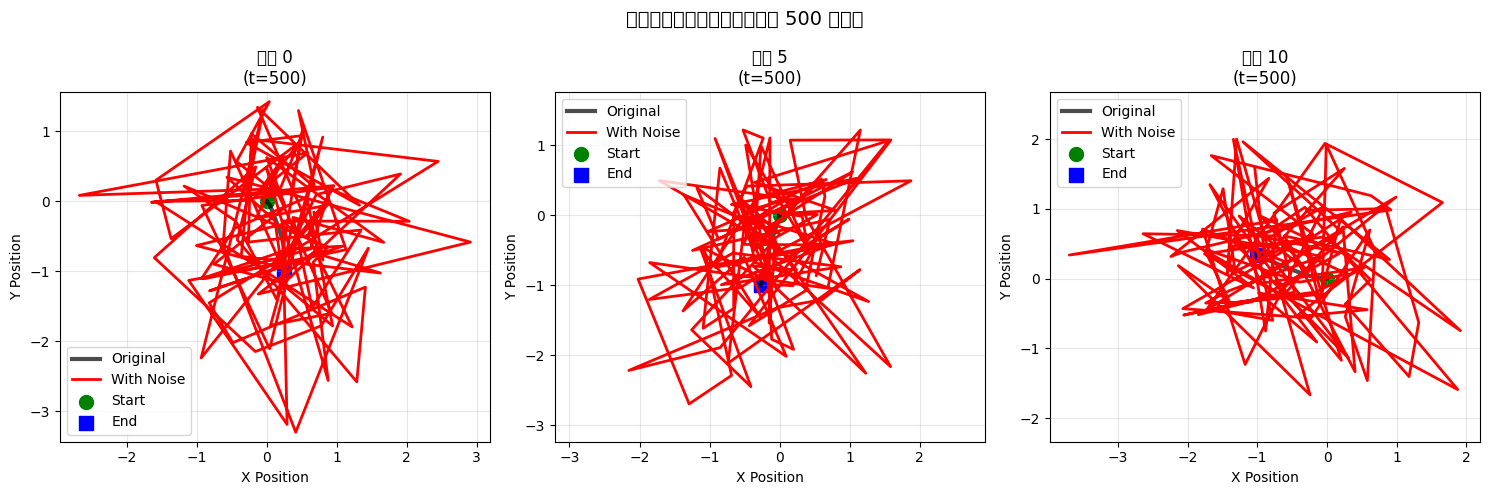

In [11]:
def compare_diffusion_across_trajectories(trajectory_indices=[0, 1, 2], diffusion_step=500):
    """
    複数の軌道で同じ拡散ステップを比較
    """
    fig, axes = plt.subplots(1, len(trajectory_indices), figsize=(5*len(trajectory_indices), 5))
    if len(trajectory_indices) == 1:
        axes = [axes]
    
    for i, traj_idx in enumerate(trajectory_indices):
        original_trajectory = torch.tensor(trajectories[traj_idx:traj_idx+1], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            low_freq, high_freq = model.decomposer.decompose(original_trajectory)
            
            # ノイズ追加
            t = torch.tensor([diffusion_step], device=device, dtype=torch.long)
            noisy_high_freq = model.diffusion.add_noise(high_freq, t)
            reconstructed_trajectory = low_freq + noisy_high_freq
            
            # 可視化
            orig_cpu = original_trajectory[0].cpu().numpy()
            traj_cpu = reconstructed_trajectory[0].cpu().numpy()
            
            ax = axes[i]
            ax.plot(orig_cpu[:, 0], orig_cpu[:, 1], 'k-', linewidth=3, alpha=0.7, label='Original')
            ax.plot(traj_cpu[:, 0], traj_cpu[:, 1], 'r-', linewidth=2, label='With Noise')
            ax.scatter(orig_cpu[0, 0], orig_cpu[0, 1], c='green', s=100, marker='o', label='Start')
            ax.scatter(orig_cpu[-1, 0], orig_cpu[-1, 1], c='blue', s=100, marker='s', label='End')
            
            ax.set_title(f'軌道 {traj_idx}\n(t={diffusion_step})')
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axis('equal')
    
    plt.suptitle(f'異なる軌道での拡散ステップ {diffusion_step} の比較', fontsize=14)
    plt.tight_layout()
    plt.show()

# 3つの異なる軌道を比較
compare_diffusion_across_trajectories([0, 5, 10], diffusion_step=500)

## ノイズレベルの定量的分析

拡散過程でのノイズレベルを定量的に分析します。

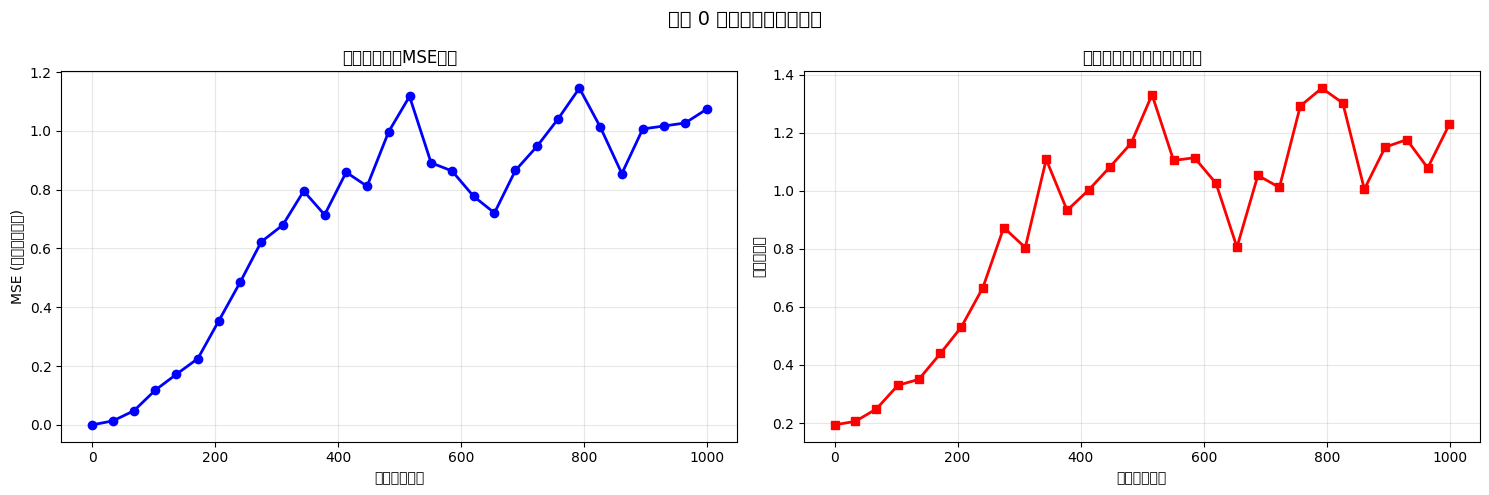

In [12]:
def analyze_noise_levels(trajectory_idx=0, num_steps=50):
    """
    拡散過程でのノイズレベルを定量的に分析
    """
    original_trajectory = torch.tensor(trajectories[trajectory_idx:trajectory_idx+1], dtype=torch.float32).to(device)
    
    step_indices = np.linspace(0, model.diffusion.num_timesteps-1, num_steps, dtype=int)
    mse_values = []
    variance_values = []
    
    with torch.no_grad():
        low_freq, high_freq = model.decomposer.decompose(original_trajectory)
        orig_cpu = original_trajectory[0].cpu().numpy()
        
        for t_step in step_indices:
            # ノイズ追加
            t = torch.tensor([t_step], device=device, dtype=torch.long)
            noisy_high_freq = model.diffusion.add_noise(high_freq, t)
            reconstructed_trajectory = low_freq + noisy_high_freq
            traj_cpu = reconstructed_trajectory[0].cpu().numpy()
            
            # MSE計算
            mse = np.mean((orig_cpu - traj_cpu) ** 2)
            mse_values.append(mse)
            
            # 分散計算
            variance = np.var(traj_cpu)
            variance_values.append(variance)
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # MSEの変化
    ax1.plot(step_indices, mse_values, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('拡散ステップ')
    ax1.set_ylabel('MSE (元軌道との差)')
    ax1.set_title('拡散過程でのMSE変化')
    ax1.grid(True, alpha=0.3)
    
    # 分散の変化
    ax2.plot(step_indices, variance_values, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('拡散ステップ')
    ax2.set_ylabel('軌道の分散')
    ax2.set_title('拡散過程での軌道分散変化')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'軌道 {trajectory_idx} のノイズレベル分析', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return step_indices, mse_values, variance_values

# ノイズレベルの分析
steps, mse_vals, var_vals = analyze_noise_levels(trajectory_idx=0, num_steps=30)

## まとめ

このノートブックでは以下の可視化を提供しています：

1. **基本的な拡散過程**: 9つのステップで拡散過程を概観
2. **詳細なノイズ進行**: 複数のステップを1つのプロットで表示
3. **インタラクティブ可視化**: スライダーで任意のステップを確認
4. **軌道間比較**: 異なる軌道での同じ拡散ステップを比較
5. **定量的分析**: MSEと分散の変化を分析

これらの機能を使って、拡散モデルがどのように軌道データにノイズを追加していくかを詳細に観察できます。